In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
path = "/Users/christiannass/Documents/Arbeit/AxaChallenge"

In [45]:
# Load tripdata for 2019
dfs = []
for year in [2019]:
    dirpath = f"{path}/data/{year}-citibike-tripdata"
    csv_files = [os.path.join(dirpath, f) for f in os.listdir(dirpath) if f.endswith('tripdata.csv')]
    for fpath in csv_files:
        df = pd.read_csv(fpath)
        if "/" in df['StartTime'].iloc[0]:
            df['StartTime'] = pd.to_datetime(df['StartTime'], format='%m/%d/%Y %H:%M:%S')
        else:
            df['StartTime'] = pd.to_datetime(df['StartTime'], format='ISO8601')
        dfs.append(df)
df_trips = pd.concat(dfs, axis=0, ignore_index=True)
df_trips.head(5)

TripDuration               StartTime  StartStationID  EndDtationID  BikeID  \
0           897 2019-07-01 00:00:00.132           493.0         454.0   18340   
1           267 2019-07-01 00:00:05.178          3143.0        3226.0   21458   
2          2201 2019-07-01 00:00:05.213           317.0        3469.0   39874   
3          1660 2019-07-01 00:00:08.601           249.0         369.0   38865   
4           109 2019-07-01 00:00:12.158          3552.0        3538.0   30256   

     UserType  BirthYear  Gender  
0  Subscriber       1966       1  
1    Customer       1996       1  
2  Subscriber       1986       1  
3  Subscriber       1988       1  
4  Subscriber       1997       1

Text(0, 0.5, 'Number of trips')

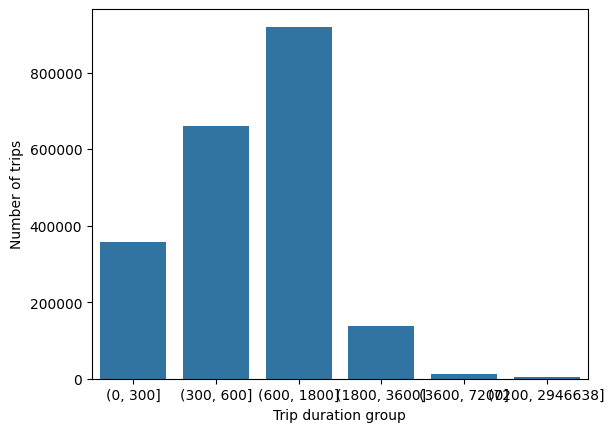

In [20]:
df_trips['TripDuration_bins'] = pd.cut(df_trips['TripDuration'], [0, 300, 600, 1800, 3600, 7200, df['TripDuration'].max()])
sns.barplot(x='TripDuration_bins', y='TripDuration', data=df_trips, estimator=np.size)
plt.xlabel('Trip duration group')
plt.ylabel('Number of trips')

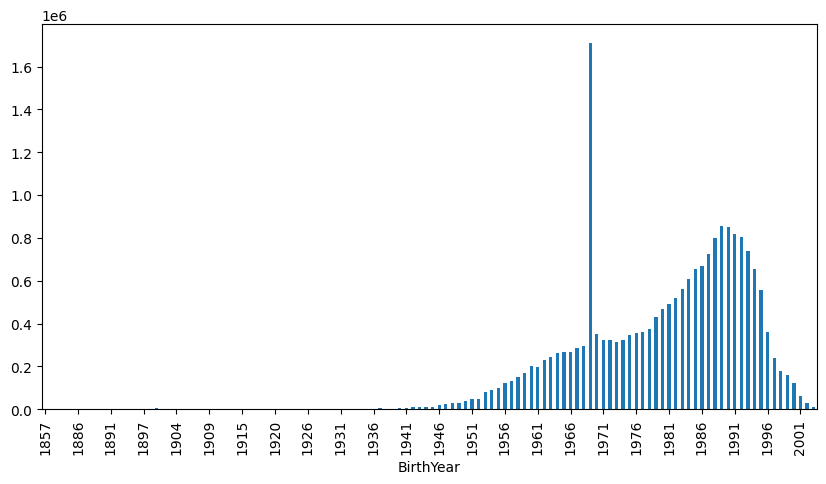

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
df_trips["BirthYear"].groupby(df_trips["BirthYear"]).count().plot(ax=axs, kind="bar")
axs.xaxis.set_major_locator(MultipleLocator(5))

[Text(0, 0, 'Unknown'), Text(1, 0, 'Male'), Text(2, 0, 'Female')]

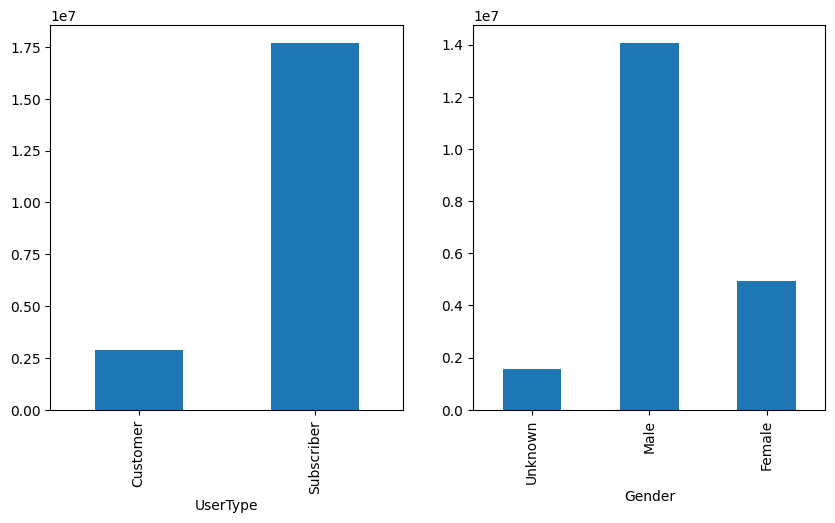

In [47]:
from matplotlib.ticker import MultipleLocator
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df_trips["UserType"].groupby(df_trips["UserType"]).count().plot(ax=axs[0], kind="bar")
df_trips["Gender"].groupby(df_trips["Gender"]).count().plot(ax=axs[1], kind="bar")
axs[1].set_xticklabels(['Unknown', 'Male', 'Female'])

<Axes: xlabel='Hour', ylabel='Number of trips started'>

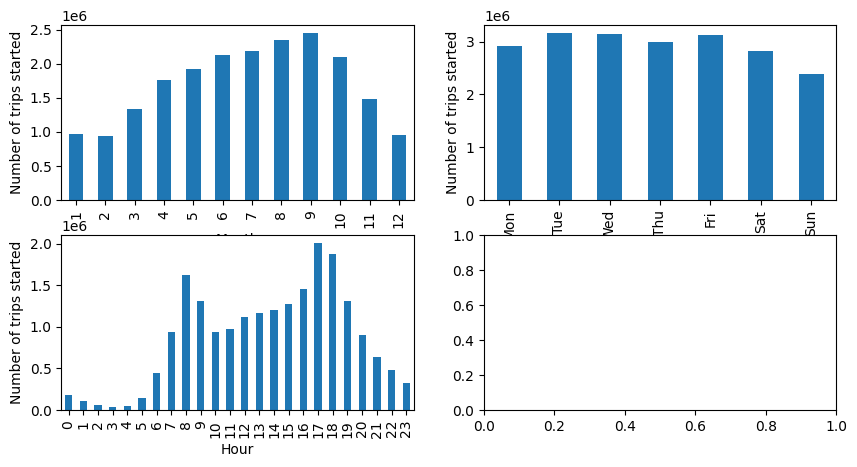

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
df_trips["StartTime"].groupby(df_trips["StartTime"].dt.month).count().plot(ax=axs[0,0], kind="bar", xlabel="Month", ylabel="Number of trips started")
df_trips["StartTime"].groupby(df_trips["StartTime"].dt.day_of_week).count().plot(ax=axs[0,1], kind="bar", xlabel="Day of week", ylabel="Number of trips started")
axs[0,1].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
df_trips["StartTime"].groupby(df_trips["StartTime"].dt.hour).count().plot(ax=axs[1,0], kind="bar", xlabel="Hour", ylabel="Number of trips started")



In [4]:
df_stations = pd.read_csv(f"{path}/data/2019-citibike-tripdata/stations.csv")

# 1. Analyse stations: Bike redistribution and open/closing stations

In [5]:
# count starts
s_stationStarts = df_trips["StartStationID"].groupby(df_trips["StartStationID"]).count()
s_stationStarts.name = "N_starts"
s_stationStarts.index.name = "ID"
# count ends
s_stationEnds = df_trips["EndDtationID"].groupby(df_trips["EndDtationID"]).count()
s_stationEnds.name = "N_ends"
s_stationEnds.index.name = "ID"
#
df_stations = df_stations.merge(pd.concat([s_stationStarts, s_stationEnds], axis=1), on="ID")

In [6]:
df_stations["StartEndDiff"] = df_stations["N_starts"] - df_stations["N_ends"]

In [7]:
import branca.colormap as cm
import folium
min_diff = df_stations["StartEndDiff"].min()
max_diff = df_stations["StartEndDiff"].max()
linear = cm.LinearColormap(["blue", "green", "red"], vmin=min_diff, vmax=max_diff)

m = folium.Map(
    max_bounds=True,
    location=[40.76, -73.98], 
    zoom_start=11, 
    tiles="CartoDB positron", 
    control_scale=True,
)

for station in df_stations.itertuples(index=False):
    folium.Circle(
        location=[station.Lat, station.Lng],
        radius= 30,
        color=linear(station.StartEndDiff),
        fill_opacity=1.0,
        fill_color=linear(station.StartEndDiff),
        popup=f"{station.Name}: In 2019 {station.StartEndDiff} times more often Route start than end",
        tooltip=f"{station.Name}",
    ).add_to(m)
print("Map of Citibike stations in NYC in 2019")
print("A positive value means more starts and ends")
print("Green: Station is as often a start point as it is an end")
print("Red: Much more often start point. Have to bring Bikes frequently to these stations.")
print("Blue: Much more often end point. Have to pick up Bikes from these stations and distribute them to red stations.")
m.add_child(linear)
m

Map of Citibike stations in NYC in 2019
A positive value means more starts and ends
Green: Station is as often a start point as it is an end
Red: Much more often start point. Have to bring Bikes frequently to these stations.
Blue: Much more often end point. Have to pick up Bikes from these stations and distribute them to red stations.


- For some reason upper Manhattan more often start point and lower Manhattan more often end point. (Party and take subway back home? Could verify this based on weekdays and times. Probably more often need to get to work fast.)
- Have to move more than 30 bikes per day to the station with the largest difference
- One could make more precise predictions on when to redistribute bikes based on certain timewindows in which one sees large differences
    - Even though net flow is zero, there might be not enough bikes in Brooklyn in the morning for all customers to get to their work in Manhattan
    - But CitiBike will have detailed information on the current location of the bikes at any point in time, which makes it a lot easier

In [55]:
# Check how often bikes are redistributed and where
df_trips = df.sort_values(by=["BikeID", "StartTime"])
mask = (df_trips['BikeID'] == df_trips['BikeID'].shift(1)) & (df_trips['StartStationID'] != df_trips['EndDtationID'].shift(1))

df_jumps = df_trips[mask]
print(f"{len(df_jumps)} bikes haven been redistributed in 2019. ({len(df_jumps)/len(df_trips)}% of trips)")


56453 bikes haven been redistributed in 2019. (0.02697779241154311% of trips)


In [56]:
df_jumps
s_stationJumps = df_trips["StartStationID"].groupby(df_trips["StartStationID"]).count()
s_stationJumps.name = "N_jumps"
s_stationJumps.index.name = "ID"
df_stations = df_stations.merge(s_stationJumps, on="ID")

max_jumps = df_stations["N_jumps"].max()
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=0, vmax=max_jumps)

m = folium.Map(
    max_bounds=True,
    location=[40.76, -73.98], 
    zoom_start=11, 
    tiles="CartoDB positron", 
    control_scale=True,
)

for station in df_stations.itertuples(index=False):
    folium.Circle(
        location=[station.Lat, station.Lng],
        radius= 30,
        color=linear(station.N_jumps),
        fill_opacity=1.0,
        fill_color=linear(station.N_jumps),
        popup=f"{station.Name}: {station.N_jumps} times bikes got redistributed to this station in 2019",
        tooltip=f"{station.Name}",
    ).add_to(m)
m.add_child(linear)
print(f"Stations where bikes often got redistributed to are red")
m

Stations where bikes often got redistributed to are red


- The results in this plot are compatible with the results from the plot above but not for every station
- One has to be careful with closeby stations

In [9]:
df_stations["StartEndSum"] = df_stations["N_starts"] + df_stations["N_ends"]

In [10]:
max_visits = df_stations["StartEndSum"].max()
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=0, vmax=max_visits)

m = folium.Map(
    max_bounds=True,
    location=[40.76, -73.98], 
    zoom_start=11, 
    tiles="CartoDB positron", 
    control_scale=True,
)

for station in df_stations.itertuples(index=False):
    folium.Circle(
        location=[station.Lat, station.Lng],
        radius= 30,
        color=linear(station.StartEndSum),
        fill_opacity=1.0,
        fill_color=linear(station.StartEndSum),
        popup=f"{station.Name}: {station.StartEndSum} times started or ended a trip at this station in 2019",
        tooltip=f"{station.Name}",
    ).add_to(m)
m.add_child(linear)
print(f"Station with least visits is {df_stations['Name'].iloc[df_stations['StartEndSum'].idxmin()]} with {df_stations['StartEndSum'].min()} visits.")
print(f"Number of stations is {len(df_stations)}")
m

Station with least visits is W 39 St & 9 Ave with 6.0 visits.
Number of stations is 936


In [11]:
visits_less1p = df_stations[df_stations['StartEndSum']< max_visits*0.01]
print(f"{len(visits_less1p)} stations have less than {max_visits*0.01} visits, which is less than 1% of the visits of the most frequently visited station")
print("Those are highlighted in the following map")

m = folium.Map(
    max_bounds=True,
    location=[40.76, -73.98], 
    zoom_start=11, 
    tiles="CartoDB positron", 
    control_scale=True,
)

for station in visits_less1p.itertuples(index=False):
    folium.Circle(
        location=[station.Lat, station.Lng],
        radius= 30,
        color=linear(station.StartEndSum),
        fill_opacity=1.0,
        fill_color=linear(station.StartEndSum),
        popup=f"{station.Name}: {station.StartEndSum} times started or ended a trip at this station in 2019",
        tooltip=f"{station.Name}",
    ).add_to(m)
m.add_child(linear)
m

118 stations have less than 3121.11 visits, which is less than 1% of the visits of the most frequently visited station
Those are highlighted in the following map


- Mainly stations in Brooklyn
- Two large subway stations are at that long road (Broadway)
- If there are good subway connections bikes are only need for the "last-mile". Hence, only need bike stations directly at the subway stations but not so many close by to the stations.
- Stations at the outer cricle that are used most are north of central park. Might be best to expand with new stations in that direction

# 2. Forecasting (day-by-day) 

In [2]:
import xgboost as xgb
import sklearn
import holidays
us_hldys = holidays.country_holidays('US')

In [ ]:
# Other features:
# Number of stations
# UserType, BirthYear, Gender?

In [74]:
# Prepare data
dfs = []

# for year in [2013, 2014, 2015, 2016, 2017, 2018, 2019]:
for year in [2013, 2014, 2015, 2016, 2017, 2018, 2019]:
    dirpath = f"{path}/data/{year}-citibike-tripdata"
    csv_files = [os.path.join(dirpath, f) for f in os.listdir(dirpath) if f.endswith('tripdata.csv')]
    for fpath in csv_files:
        print(fpath)
        df = pd.read_csv(fpath)
        if "/" in df['StartTime'].iloc[0]:
            if str(df['StartTime'].iloc[0]).count(':')==1:
                df['StartTime'] = df['StartTime']+":00"
            df['StartTime'] = pd.to_datetime(df['StartTime'], format='%m/%d/%Y %H:%M:%S')
        else:
            df['StartTime'] = pd.to_datetime(df['StartTime'], format='ISO8601')
        
        df1 = df.groupby(df['StartTime'].dt.date).size().reset_index(name='Nrides')
        df1 = df1.rename(columns={"StartTime": "Date"})
        df1["Date"] = pd.to_datetime(df1['Date'])
        df1["Year"] = df1["Date"].dt.year
        df1["Month"] = df1["Date"].dt.month
        df1["Wday"] = df1["Date"].dt.day_of_week
        df1['isHoliday'] = df1["Date"].apply(lambda x: x in us_hldys)
        dfs.append(df1)
df = pd.concat(dfs, axis=0, ignore_index=True)
df.head(5)

/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2013-citibike-tripdata/201306-tripdata.csv
/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2013-citibike-tripdata/201312-tripdata.csv
/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2013-citibike-tripdata/201307-tripdata.csv
/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2013-citibike-tripdata/201310-tripdata.csv
/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2013-citibike-tripdata/201311-tripdata.csv
/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2013-citibike-tripdata/201309-tripdata.csv
/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2013-citibike-tripdata/201308-tripdata.csv
/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2014-citibike-tripdata/201401-tripdata.csv
/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2014-citibike-tripdata/201406-tripdata.csv
/Users/christiannass/Documents/Arbeit/AxaChallenge/data/2014-citibike-tripdata/201412-tripdata.csv
/Users/chr

Date  Nrides  Year  Month  Wday  isHoliday
0 2013-06-01    8722  2013      6     5      False
1 2013-06-02   15971  2013      6     6      False
2 2013-06-03    7598  2013      6     0      False
3 2013-06-04   15782  2013      6     1      False
4 2013-06-05   15690  2013      6     2      False

In [78]:
df = df.sort_values("Date")
X, y = df[["Year", "Month", "Wday", "isHoliday"]], df["Nrides"]
X_train = X[X["Year"] <2018]
X_val   = X[X["Year"]==2018]
X_test  = X[X["Year"]>=2019]
y_train = y[X["Year"] <2018]
y_val   = y[X["Year"]==2018]
y_test  = y[X["Year"]>=2019]

In [79]:
df[df["Year"]==2019]

Date  Nrides  Year  Month  Wday  isHoliday
2125 2019-01-01   21962  2019      1     1       True
2126 2019-01-02   37797  2019      1     2      False
2127 2019-01-03   41676  2019      1     3      False
2128 2019-01-04   43922  2019      1     4      False
2129 2019-01-05   17432  2019      1     5      False
...         ...     ...   ...    ...   ...        ...
2090 2019-12-27   31808  2019     12     4      False
2091 2019-12-28   28520  2019     12     5      False
2092 2019-12-29   17968  2019     12     6      False
2093 2019-12-30   12138  2019     12     0      False
2094 2019-12-31   31510  2019     12     1      False

[365 rows x 6 columns]

In [80]:
# gamma, min_child_weight, reg_alpha, reg_lambda
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.01,
    "n_estimators": 1500,
    "max_depth": 4,
}
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_val_pred))
r2 = sklearn.metrics.r2_score(y_val, y_val_pred)


print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')
model.feature_importances_
# names (year, month, weekday, holiday)

RMSE: 12336.464
R²: 0.597


array([0.42794406, 0.40468803, 0.08038381, 0.08698415], dtype=float32)

In [122]:
from sklearn.model_selection import GridSearchCV

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "learning_rate": 0.1,
    "n_estimators": 100
}
model = xgb.XGBRegressor(**params)

#fit_params = {
#    "early_stopping_rounds":5,
#    "eval_metric" : "mse", 
#    "eval_set" : [[X_val, y_val]]
#}

param_grid = {
    'n_estimators': [400, 600],
    'max_depth': [4, 5],
    'learning_rate': [0.05, 0.1],
    # 'min_child_weight': [100],
    # 'gamma': [0.1, 1., 10.],
    'reg_alpha': [20, 50]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_search.fit(X_train, y_train, **fit_params)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400, 'reg_alpha': 50}


In [123]:
# hyperopt depracted at python 3.12
# early stopping bekomme ich errors
# plot mse curve over training periods

# optimised results
model = xgb.XGBRegressor(**grid_search.best_params_)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_val_pred))
r2 = sklearn.metrics.r2_score(y_val, y_val_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')
# slightly better

RMSE: 10139.342
R²: 0.728


In [124]:
# Final training with validation dataset
X_train = X[X["Year"] <2019]
X_test  = X[X["Year"]>=2019]
y_train = y[X["Year"] <2019]
y_test  = y[X["Year"]>=2019]

model = xgb.XGBRegressor(**grid_search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
r2 = sklearn.metrics.r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 15439.030
R²: 0.483


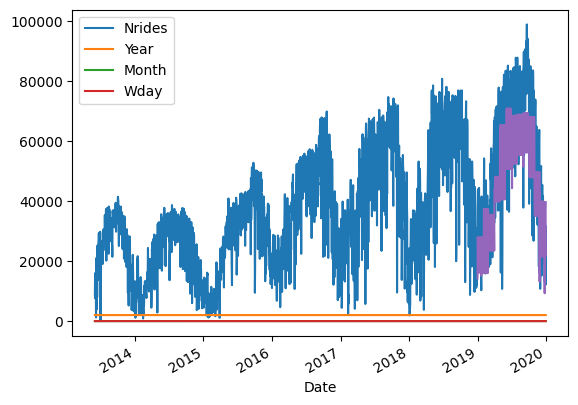

In [125]:
fig, ax = plt.subplots()
df.set_index('Date').plot(ax=ax)
ax.plot(df["Date"].loc[X["Year"]>=2019], y_pred)

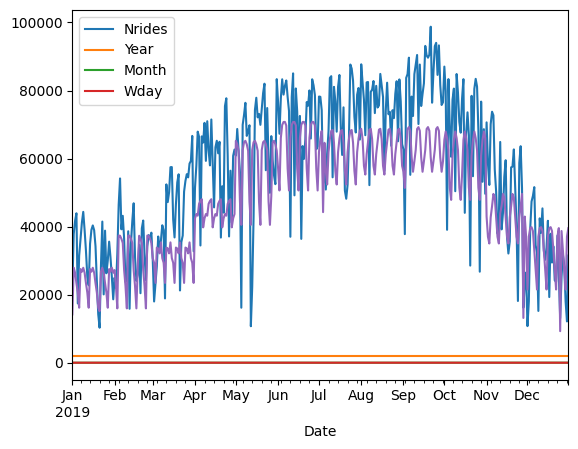

In [126]:
fig, ax = plt.subplots()
df[df["Year"]>=2019].set_index('Date').plot(ax=ax)
ax.plot(df["Date"].loc[X["Year"]>=2019], y_pred)